In [2]:
import sys; sys.path.insert(0, '..')
from database.dataset import *

from feature_extraction.feature_extraction import CandidatesFeatureExtraction
from candidate_proposal.hough_mc import HoughCalcificationDetection
from general_utils.plots import plot_bboxes_over_image, simple_im_show, simple_im_show2
from metrics.metrics import get_tp_fp_fn, quick_circle_comparison, circle_comparison
import matplotlib.pyplot as plt
import pickle
from skimage.feature import graycomatrix,graycoprops
from general_utils.utils import min_max_norm, patch_coordinates_from_center
import pywt


#### Database initialization

In [7]:
db = INBreast_Dataset(
        return_lesions_mask=True,
        level='image',
        max_lesion_diam_mm=1.0,
        partitions=['train'],
        extract_patches=True,
        extract_patches_method='all',  # 'centered'
        patch_size=256,
        stride=256,
        min_breast_fraction_roi=0.5,
        normalize=None,
        n_jobs=-1,
)

#### Detector initialization

In [3]:
dehazing_params = {'omega': 0.9, 'window_size': 11, 'radius': 40, 'eps': 1e-5}

hough1_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 20,
                 'param1': 300, 'param2': 8,  'minRadius': 2, 'maxRadius': 20}

hough2_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 20,
                 'param1': 300, 'param2': 10,  'minRadius': 2, 'maxRadius': 20}

back_ext_radius = 50

erosion_iter = 20
erosion_size = 5


hd = HoughCalcificationDetection(dehazing_params, back_ext_radius,
                                 Path.cwd().parent / 'data/hough_img',    # "/media/vzalevskyi/DATA/ProjectsData/calc-det/no_dehaizing",
                                 hough1_params, hough2_params,
                                 erosion_iter=erosion_iter,
                                 erosion_size=erosion_size)


### Experiments

#### GLCM

In [39]:
idx = 0
db_sample = db[idx]
image = db_sample['img']
image_id = db.df.iloc[idx].img_id
image_mask = db_sample['lesion_mask']
patch_x1, patch_x2, patch_y1, patch_y2 = patch_coordinates_from_center(1042, 2295, image.shape, 30)
image_patch = image[patch_y1:patch_y2, patch_x1:patch_x2]
#cfe  = CandidatesFeatureExtraction(patch_size=14)


glcm_decomp = graycomatrix(min_max_norm(image_patch,max_val=255).astype(np.uint8),[2],[0,np.pi, np.pi/4, np.pi/2],normed=True)
LL1,(LH1,HL1,HH1) = pywt.dwt2(min_max_norm(image_patch),'haar')
glcm_LL1 = graycomatrix(min_max_norm(LL1,max_val=255).astype(np.uint8),[2],[0,np.pi, np.pi/4, np.pi/2],normed=True)

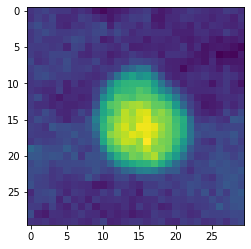

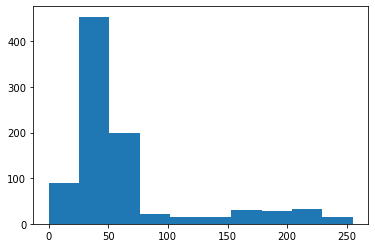

In [40]:
plt.imshow(min_max_norm(image_patch,max_val=255).astype(np.uint8))
plt.show()
min_max_norm(image_patch,max_val=255).astype(np.uint8).max()
plt.hist(min_max_norm(image_patch,max_val=255).astype(np.uint8).flatten())
plt.show()

In [41]:
(glcm_LL1[:,:,0,0] == glcm_LL1[:,:,0,1]).sum()

65208

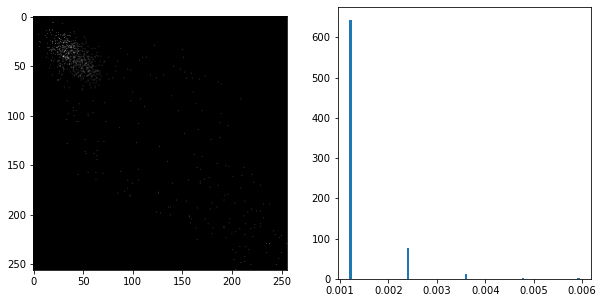

64803
max: 0.005952380952380952 0.0
mean: 1.52587890625e-05


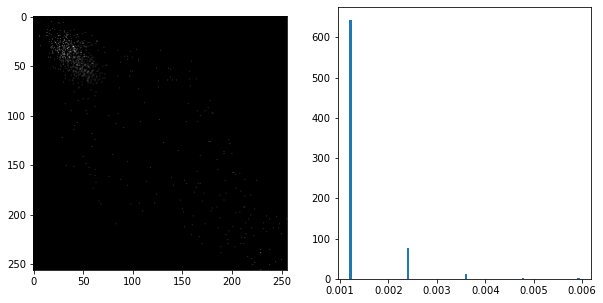

64803
max: 0.005952380952380952 0.0
mean: 1.52587890625e-05


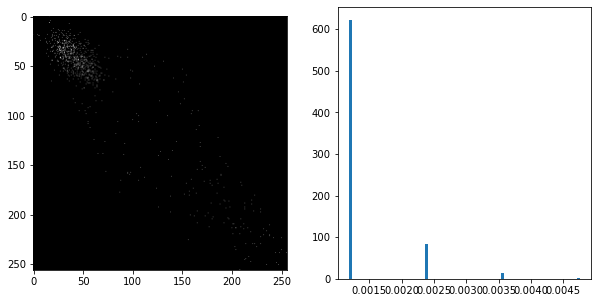

64814
max: 0.0047562425683709865 0.0
mean: 1.5258789062499998e-05


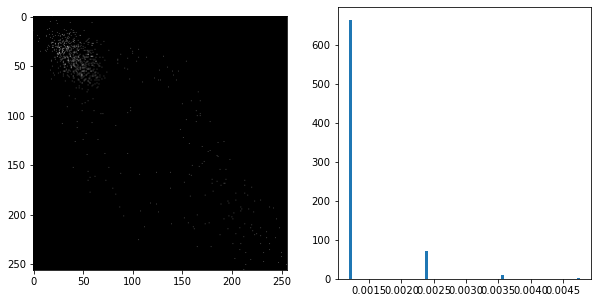

64791
max: 0.004761904761904762 0.0
mean: 1.52587890625e-05


In [46]:
for idx in range(4):
    glcm = glcm_decomp[:,:,0,idx]
    f,ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(glcm,cmap='gray')
    ax[1].hist(glcm[(glcm != 0)].flatten(),bins=100) #(glcm < 25) & 
    plt.show()
    print((glcm==0).sum())
    print(f'max: {glcm.max()}',np.quantile(glcm, q=0.1))
    print(f'mean: {glcm.mean()}')

In [3]:
import pywt
from general_utils.utils import min_max_norm
from scipy.stats import kurtosis, skew
from skimage import feature
from general_utils.utils import crop_center_coords

In [24]:
def get_wavelet_features(patch:np.ndarray,directions=[0,np.pi]):
    """ Extracts features from an patch's haar 2-level wavelet decomposition (8 decompositions)
    First order statistics: mean, skewness, standard deviation, kurtosis, entropy, uniformity, relative smoothness
    GLCM features (D=5,theta = 0) [note: only in LH1, HL1 and HH1]: energy, correlation, homogeneity, contrast, 
    dissimilarity, ASM, entropy, uniformity, sum of squares, autocorrelation    

    Args:
        patch (np.ndarray): image patch (normalized)

    Returns:
        features (dict): dictionary containing all extracted features
    """
    eight_decomp = get_wavelet_decomp(patch)
    fo_features = {}
    for idx,single_decomp in enumerate(eight_decomp):
        fo_features = fo_features | wav_first_order(single_decomp,idx)
    glcm_features = {}
    for idx,single_decomp in enumerate(eight_decomp[1:4]):
        glcm_features = glcm_features | wav_glcm_features(single_decomp,idx,directions)
    return fo_features | glcm_features

def get_wavelet_decomp(patch: np.ndarray, wavelet_type = 'haar'):
    """ Gets wavelet decomposition of two levels with approximation and detail coefficients.
    Uses decimated 2D forward Discrete Wavelet Transform

    Args:
        patch (np.ndarray): image patch (normalized)
        wavelet_type (str, optional): type of wavelet for decomposition. Defaults to 'haar'.

    Returns:
        decompositions (list[np.ndarray]): list of decompositions [LL1,LH1,HL1,HH1,LL2,LH2,HL2,HH2]
    """
    LL1,(LH1,HL1,HH1) = pywt.dwt2(patch,wavelet_type) 
    LL2,(LH2,HL2,HH2) = pywt.dwt2(LL1,wavelet_type)
    return [LL1,LH1,HL1,HH1,LL2,LH2,HL2,HH2]

def wav_first_order(single_decomp: np.ndarray,idx: int):
    """ Extracts first order statistics from a single wavelet decomposition
    Features: mean, skewness, standard deviation, kurtosis, entropy, uniformity, relative smoothness

    Args:
        single_decomp (np.ndarray): single decomposition from the list [LL1,LH1,HL1,HH1,LL2,LH2,HL2,HH2]
        Note: expected to be used on the eight decompositions for correct feature naming
        idx (int): index of the decomposition from list above

    Returns:
        first_order_features (dict): dictionary containing first order features
    """
    decomp_names = ['LL1','LH1','HL1','HH1','LL2','LH2','HL2','HH2']
    patch_mean = np.mean(single_decomp)
    patch_std = np.std(single_decomp)
    patch_skew = skew(single_decomp.ravel())
    patch_kurt = kurtosis(single_decomp.ravel())
    patch_entropy,patch_unif = CandidatesFeatureExtraction.entropy_uniformity(single_decomp)
    patch_relsmooth = 1 - 1/(1+patch_std)
    return {f'patch_mean_{decomp_names[idx]}': patch_mean,
            f'patch_skew_{decomp_names[idx]}': patch_skew,
            f'patch_std_{decomp_names[idx]}': patch_std,
            f'patch_kur_{decomp_names[idx]}': patch_kurt,
            f'patch_entropy_{decomp_names[idx]}': patch_entropy, 
            f'patch_uniformity_{decomp_names[idx]}': patch_unif,
            f'patch_relsmooth_{decomp_names[idx]}': patch_relsmooth}
    
def wav_glcm_features(single_decomp: np.ndarray,idx: int,directions: list[str]):
    """Extracts features from a Gray Level Co-occurence Matrix (D=5,theta = 0) from a single wavelet decomposition
    Features: energy, correlation, homogeneity, contrast, dissimilarity, ASM, entropy, uniformity, sum of squares, autocorrelation
    
    Args:
        single_decomp (np.ndarray): single decomposition from list [LH1, HL1,HH1]
        Note: expected to be used on three decompositions for correct feature naming
        idx (int): index of the decomposition from list above

    Returns:
        glcm_features (dict): dictionary containing glcm features
    """
    decomp_names = ['LH1','HL1','HH1']
    skimage_glcm_features = ['energy','correlation','homogeneity','contrast','dissimilarity','ASM']
    
    single_decomp_glcm = feature.graycomatrix(min_max_norm(single_decomp,max_val=256).astype(np.uint8),[2],directions,normed=True)
    
    glcm_features_1 = {}
    for feature_name in skimage_glcm_features:
        feature_results = feature.graycoprops(single_decomp_glcm, prop=feature_name)
        directions_names = ['0','pi_o4','pi_o2','pi_3o4']
        for fv_idx,fv in enumerate(feature_results.ravel()): 
            glcm_features_1[f'patch_glcm_{feature_name}_{decomp_names[idx]}_{directions_names[fv_idx]}'] = fv
            
    glcm_features_2 = {}
    for glcm in single_decomp_glcm[:,:,0,:]: 
        entropy, uniformity = CandidatesFeatureExtraction.entropy_uniformity(glcm)
        sum_squares = (glcm*(1- glcm.mean())**2).sum()
        idx_grid = np.indices((glcm.shape[0], glcm.shape[1]))
        autocorrelation = (idx_grid[0, :, :]*idx_grid[1, :, :]*glcm).sum()
        
        glcm_features_2[f'patch_glcm_entropy_{decomp_names[idx]}'] = entropy
        glcm_features_2[f'patch_glcm_uniformity_{decomp_names[idx]}'] = uniformity
        glcm_features_2[f'patch_glcm_sum_squares_{decomp_names[idx]}'] = sum_squares
        glcm_features_2[f'patch_glcm_autocorrelation_{decomp_names[idx]}'] = autocorrelation
        
    return glcm_features_1 | glcm_features_2  

In [6]:
img_idx = 0
db_sample = db[img_idx]
image = db_sample['img']
image_id = db.df.iloc[img_idx].img_id
image_mask = db_sample['lesion_mask']
# coords = db[img_idx]['lesion_bboxes']
h1_circles = hd.detect(image, image_id, load_processed_images=True, hough2=False)[0]
h1_circles

array([[1042, 2295,   11],
       [1272, 1605,   19],
       [1071,  747,   19],
       ...,
       [ 732, 2194,    2],
       [ 981,  853,    2],
       [ 988, 1043,    2]])

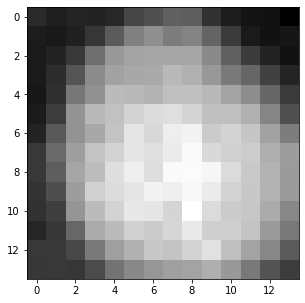

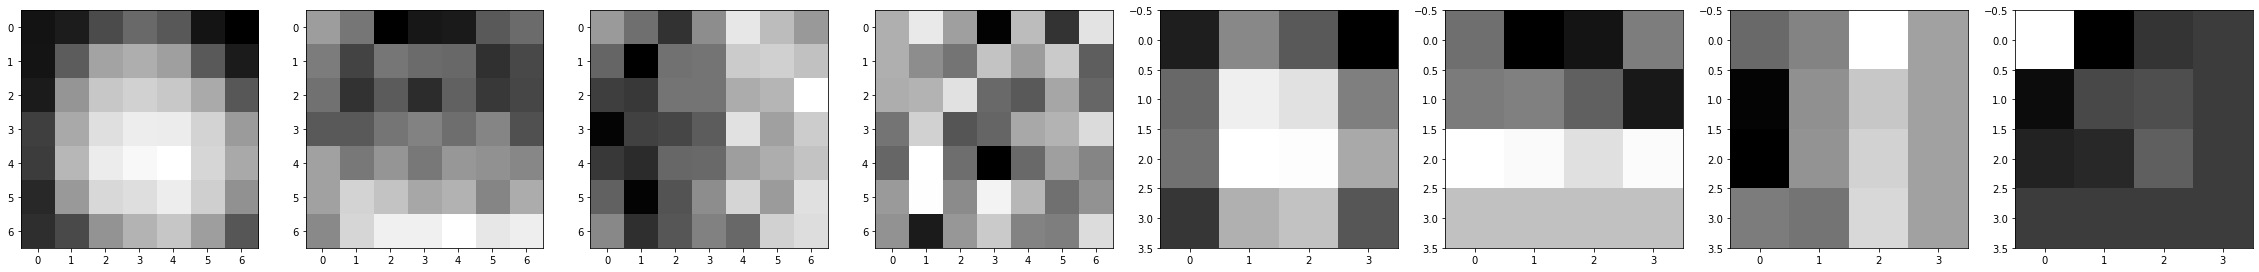

In [8]:
image = min_max_norm(db[img_idx]['img'])
patch_size = 14
patch_x1, patch_x2, patch_y1, patch_y2 = crop_center_coords(h1_circles[0][0], h1_circles[0][1], image.shape, patch_size//2)
image_patch = image[patch_y1:patch_y2, patch_x1:patch_x2]
decomp = get_wavelet_decomp(image_patch)
plt.figure(figsize=(5,5))
plt.imshow(image_patch,cmap='gray')
plt.show()
f,ax = plt.subplots(1,8,figsize=(40,5))
for idx,dec in enumerate(decomp):
    ax[idx].imshow(dec,cmap='gray')

In [25]:
patch_size = 14
patch_x1, patch_x2, patch_y1, patch_y2 = crop_center_coords(h1_circles[0][0], h1_circles[0][1], image.shape, patch_size//2)
image_patch_14 = image[patch_y1:patch_y2, patch_x1:patch_x2]

#feat_p30 = pd.DataFrame([get_wavelet_features(image_patch_30)])
feat_p14 = pd.DataFrame([get_wavelet_features(image_patch_14)])
feat_p14_dir2 = pd.DataFrame([get_wavelet_features(image_patch_14,[0, np.pi/4, np.pi/2])])
#features = pd.concat([feat_p30,feat_p14])

In [16]:
feat_p14

,patch_mean_LL1,patch_skew_LL1,patch_std_LL1,patch_kur_LL1,patch_entropy_LL1,patch_uniformity_LL1,patch_relsmooth_LL1,patch_mean_LH1,patch_skew_LH1,patch_std_LH1,...,patch_glcm_contrast_HH1_0,patch_glcm_contrast_HH1_pi,patch_glcm_dissimilarity_HH1_0,patch_glcm_dissimilarity_HH1_pi,patch_glcm_ASM_HH1_0,patch_glcm_ASM_HH1_pi,patch_glcm_entropy_HH1,patch_glcm_uniformity_HH1,patch_glcm_sum_squares_HH1,patch_glcm_autocorrelation_HH1
0,80578.599103,-0.300952,9431.654336,-1.223755,5.61471,0.020408,0.999894,-243.848021,0.265276,1695.603368,...,6308.2,6308.2,59.228571,59.228571,0.028571,0.028571,-3.203427e-16,1.0,0.0,0.0


In [26]:
feat_p14_dir2

,patch_mean_LL1,patch_skew_LL1,patch_std_LL1,patch_kur_LL1,patch_entropy_LL1,patch_uniformity_LL1,patch_relsmooth_LL1,patch_mean_LH1,patch_skew_LH1,patch_std_LH1,...,patch_glcm_dissimilarity_HH1_0,patch_glcm_dissimilarity_HH1_pi_o4,patch_glcm_dissimilarity_HH1_pi_o2,patch_glcm_ASM_HH1_0,patch_glcm_ASM_HH1_pi_o4,patch_glcm_ASM_HH1_pi_o2,patch_glcm_entropy_HH1,patch_glcm_uniformity_HH1,patch_glcm_sum_squares_HH1,patch_glcm_autocorrelation_HH1
0,80578.599103,-0.300952,9431.654336,-1.223755,5.61471,0.020408,0.999894,-243.848021,0.265276,1695.603368,...,59.228571,75.861111,68.371429,0.028571,0.027778,0.028571,-3.203427e-16,1.0,0.0,0.0


### Features test

#### Detector initialization

In [4]:
# FE class initialization
cfe  = CandidatesFeatureExtraction(patch_size=14)


#### Feature Extraction

Extracted following features: <br> - 7 (fos and statistical descriptors) x 8 decompositions <br> - 5 (statistical descriptors) x 3 glcm directions x 3 decompositions <br> - 6 (statistical descriptors) x 3 glcm directions 

In [5]:
fdf = []
for idx in tqdm(range(len(db))): # range(len(db))
    # extracting data
    db_sample = db[idx]
    image = db_sample['img']
    image_id = db.df.iloc[idx].img_id
    image_mask = db_sample['lesion_mask']

    # candidate selection
    h1_circles = hd.detect(image, image_id, load_processed_images=True, hough2=False)[0]

    # feature extraction
    res = pd.DataFrame(cfe.extract_features(h1_circles, image, image_mask,fp2tp_sample=None))
    res['img_id'] = image_id
    
    # classification
    
    fdf.append(res)

100%|██████████| 154/154 [4:16:23<00:00, 99.89s/it]   


In [6]:
# pd.to_pickle(fdf,"wavelet_glcm_alltrain_allcand_newf_p14")

In [66]:
data = pd.concat(fdf).sample(frac=1) # merge and shuffle
data['label'] = np.where(data.patch_mask_intersection > 0,1,0)
data

,patch_mean_LL1,patch_skew_LL1,patch_std_LL1,patch_kur_LL1,patch_entropy_LL1,patch_uniformity_LL1,patch_relsmooth_LL1,patch_mean_LH1,patch_skew_LH1,patch_std_LH1,...,patch_glcm_correlation_HH1,patch_glcm_homogeneity_HH1,patch_glcm_contrast_HH1,patch_glcm_dissimilarity_HH1,patch_glcm_ASM_HH1,patch_glcm_entropy_HH1,patch_glcm_uniformity_HH1,patch_mask_intersection,img_id,label
124,0.973821,0.670769,0.025556,0.370456,7.575960,0.005551,0.024920,-0.000605,-0.056924,0.004498,...,0.127433,0.025075,4655.471795,53.656410,0.005549,-3.203427e-16,1.0,0.0,24065251,0
123,1.393384,0.357284,0.043550,-0.032247,7.641537,0.005235,0.041733,-0.001608,-0.176221,0.014319,...,-0.027901,0.011038,4782.738462,57.610256,0.005233,-3.203427e-16,1.0,0.0,24055806,0
19,1.482471,1.991780,0.044531,7.173345,7.504849,0.005867,0.042633,-0.000268,0.319564,0.009027,...,-0.074022,0.031157,4579.328205,54.794872,0.005233,-3.203427e-16,1.0,1.0,20587466,1
82,0.960500,-0.198632,0.126107,-1.678250,7.682627,0.005077,0.111985,-0.004300,-0.718022,0.007385,...,-0.064574,0.059207,3932.574359,51.076923,0.007074,-3.203427e-16,1.0,0.0,20587466,0
64,1.120551,0.068118,0.037931,-0.615602,7.579315,0.005590,0.036545,-0.001518,-0.080027,0.011368,...,-0.075084,0.021586,3322.820513,45.989744,0.005181,-3.203427e-16,1.0,0.0,24055149,0


#### Evaluate visually discriminative importance of features

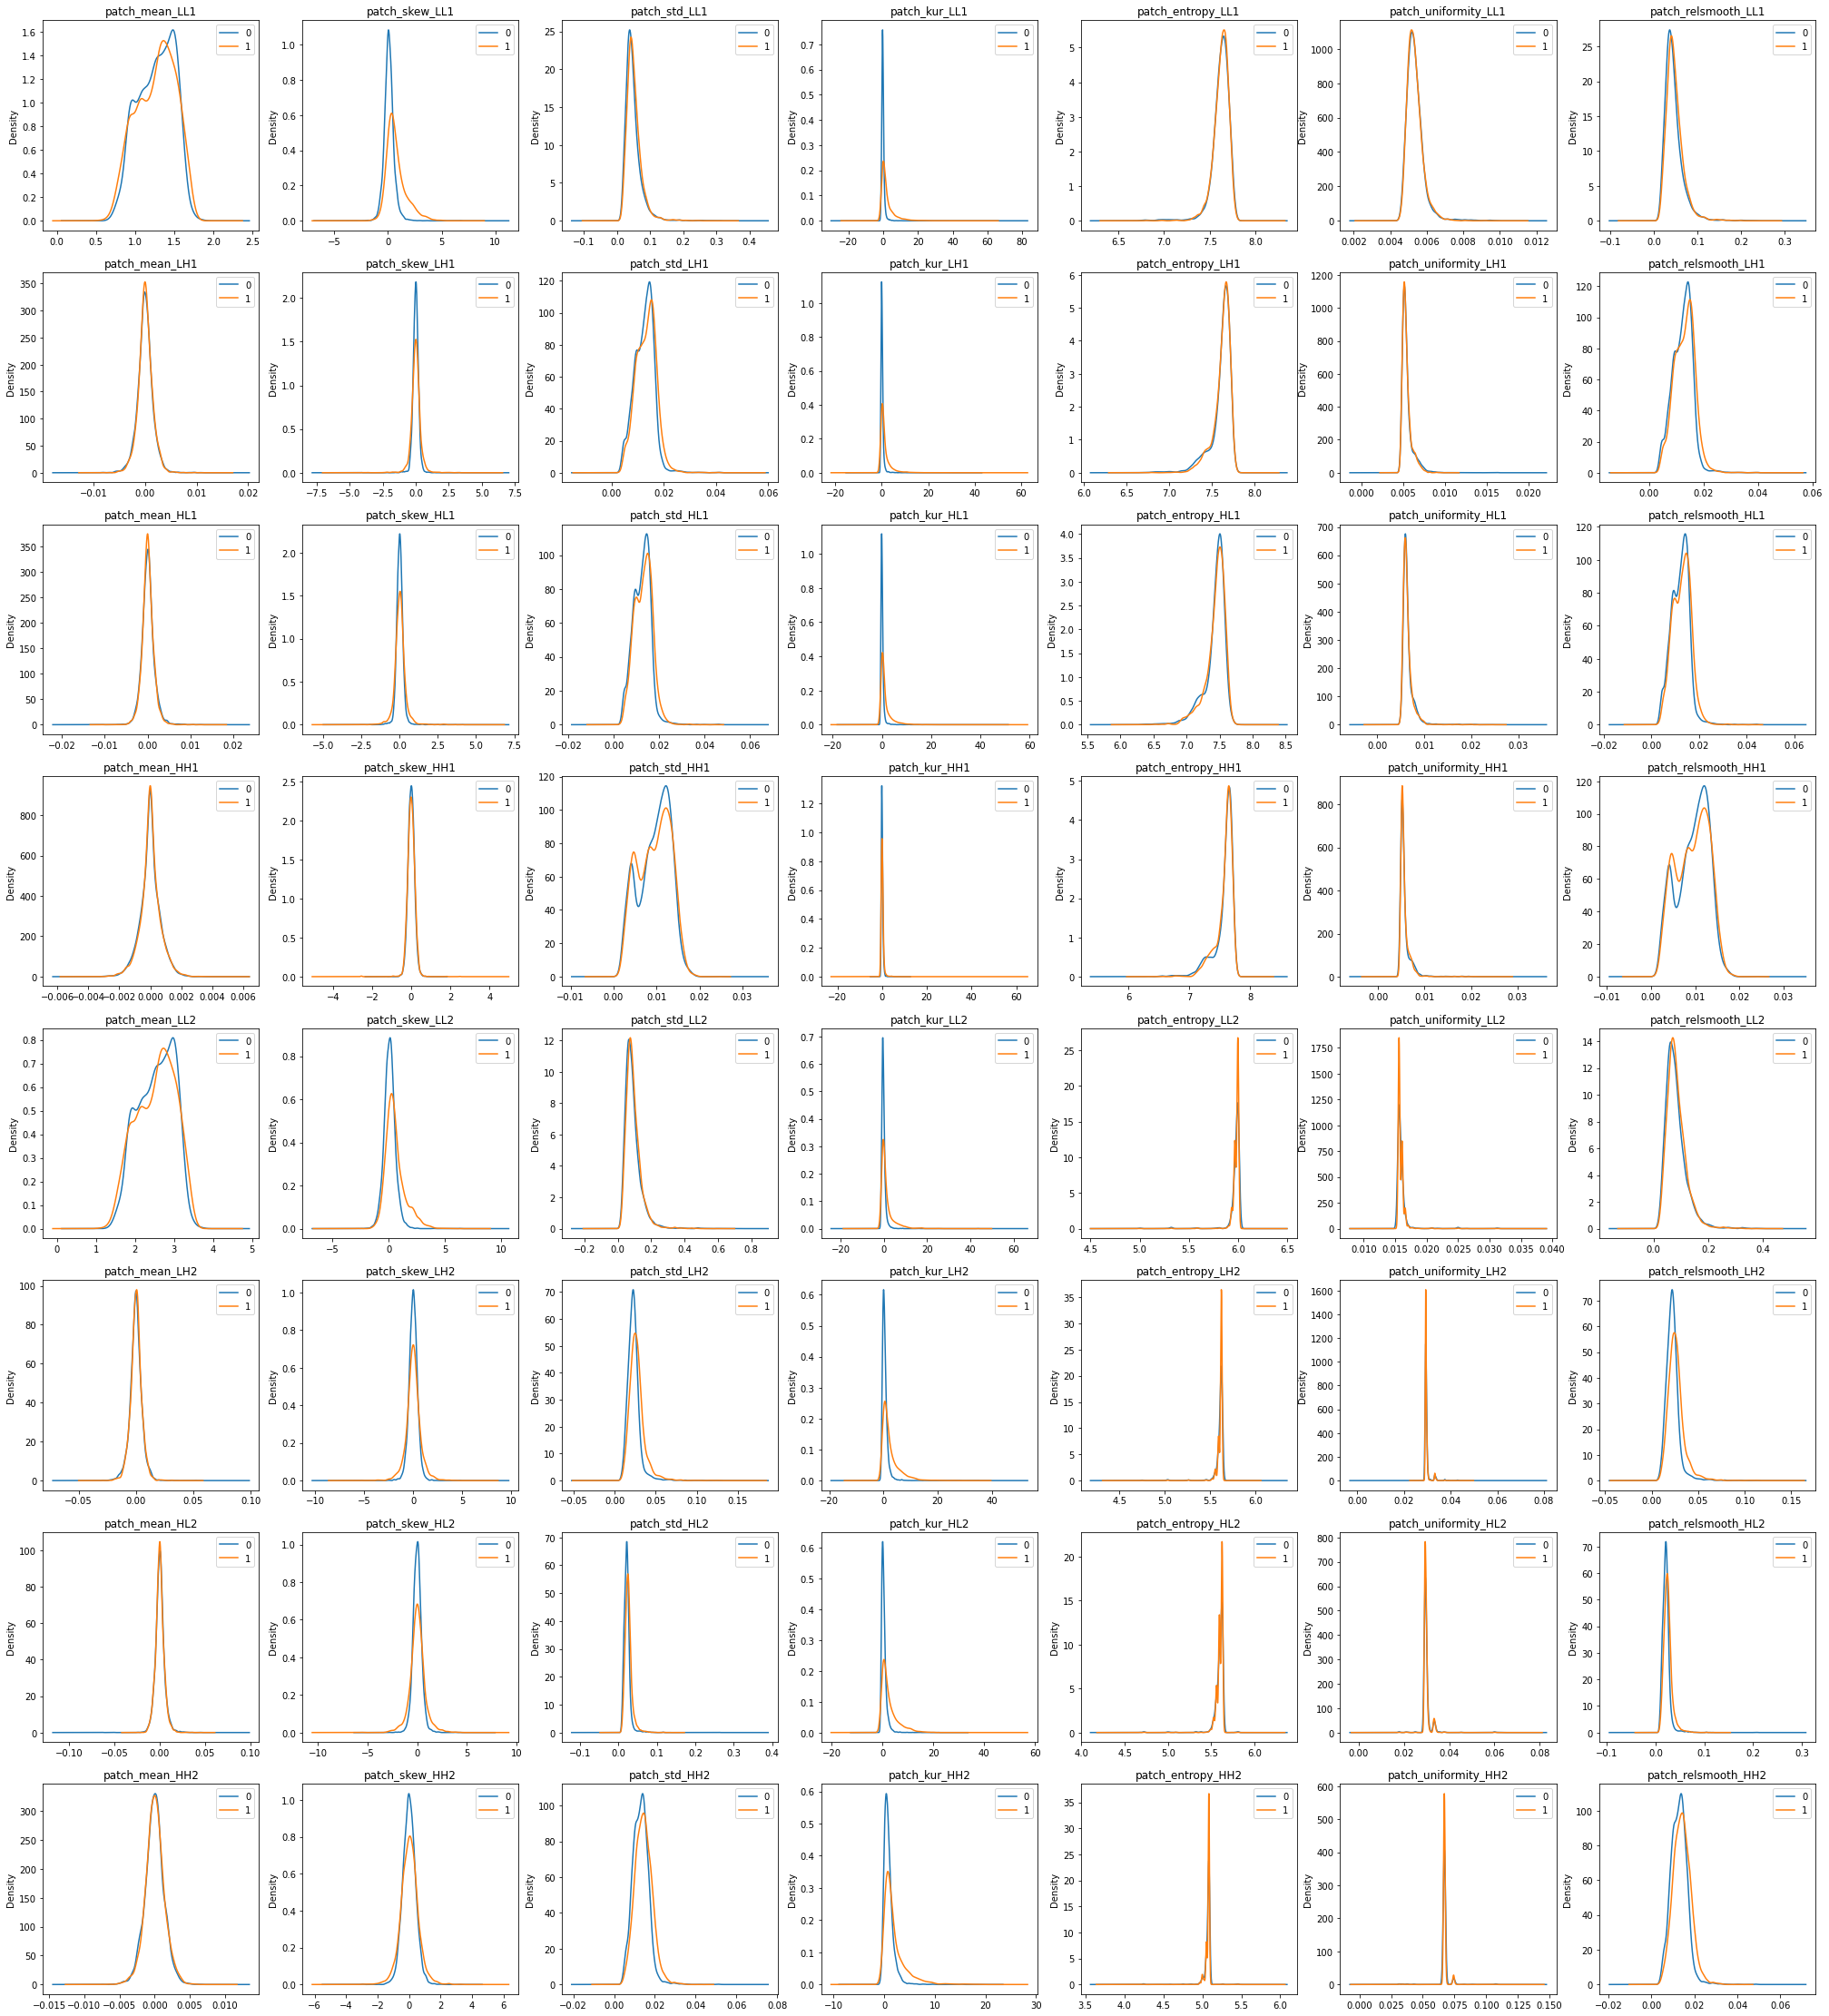

In [86]:
# f,ax = plt.subplots(2,7,figsize=(35,10))
# for col_indx in range(7):
#     data.groupby("label")[data.columns[col_indx]].plot(kind='kde',legend=True,ax=ax[0,col_indx])
#     ax[0,col_indx].set_title(data.columns[col_indx])
# for col_indx in range(7):
#     data.groupby("label")[data.columns[col_indx+7]].plot(kind='kde',legend=True,ax=ax[1,col_indx])
#     ax[1,col_indx].set_title(data.columns[col_indx+7])
    
f,ax = plt.subplots(8,7,figsize=(35,40))
for col_indx in range(7):
    for row in range(8):
        data.groupby("label")[data.columns[col_indx+7*row]].plot(kind='kde',legend=True,ax=ax[row,col_indx])
        ax[row,col_indx].set_title(data.columns[col_indx+7*row])

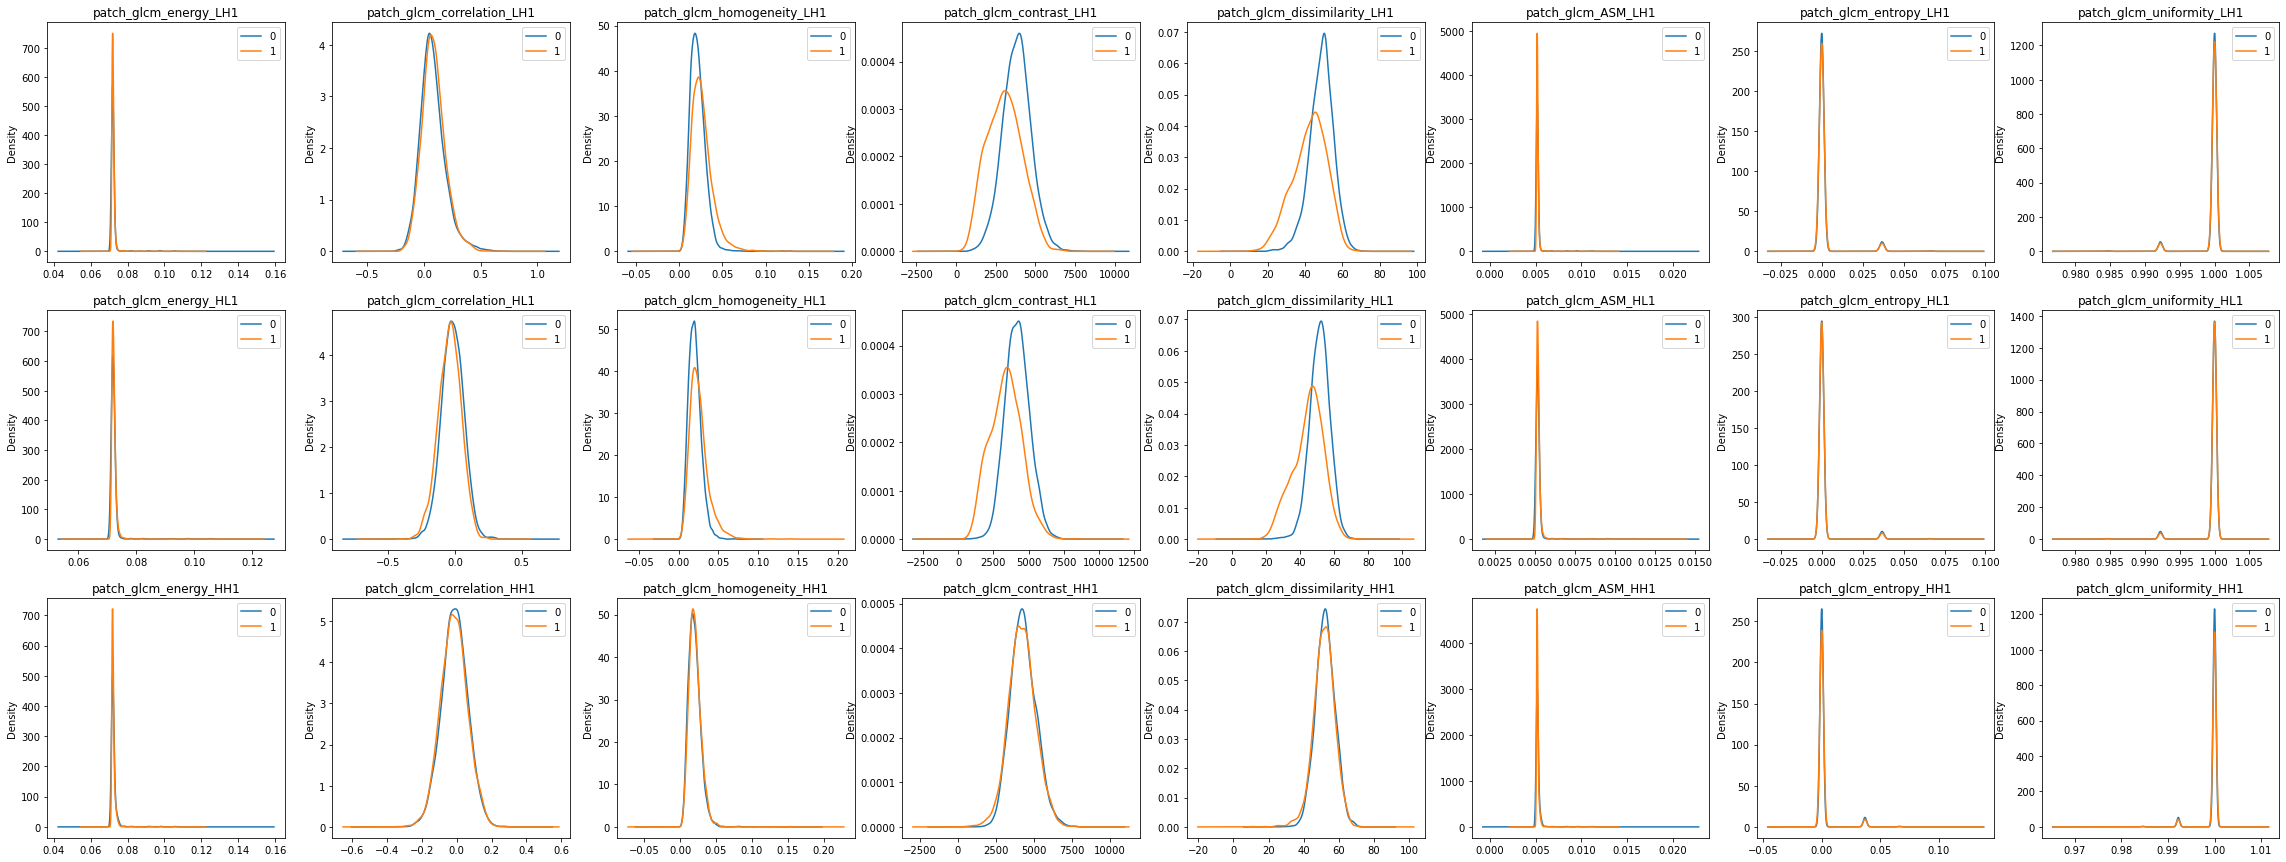

In [91]:
f,ax = plt.subplots(3,8,figsize=(40,15))
for col_indx in range(8):
    for row in range(3):
        data.groupby("label")[data.columns[col_indx+8*row+56]].plot(kind='kde',legend=True,ax=ax[row,col_indx])
        ax[row,col_indx].set_title(data.columns[col_indx+8*row+56])

### Feature selection with classifier

In [9]:
from sklearn.svm import SVC

from sklearn.metrics import f1_score, roc_auc_score

from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier

In [3]:
with open('../images/wavelet_glcm_alltrain_allcand_newf_p14', 'rb') as f:
    x = pickle.load(f)


In [4]:
data = pd.concat(x).sample(frac=1) # merge and shuffle
#,'patch_glcm_autocorrelation_HH1','patch_glcm_autocorrelation_HL1','patch_glcm_autocorrelation_LH1',
                                # 'patch_glcm_sum_squares_HH1','patch_glcm_sum_squares_HL1','patch_glcm_sum_squares_LH1'])
data 

,patch_mean_LL1,patch_skew_LL1,patch_std_LL1,patch_kur_LL1,patch_entropy_LL1,patch_uniformity_LL1,patch_relsmooth_LL1,patch_mean_LH1,patch_skew_LH1,patch_std_LH1,...,pi_o2_img_mean,pi_o2_img_range,pi_o2_img_mean_abs_deviation,pi_o2_img_rms,pi_o2_img_std,pi_o2_img_skew,pi_o2_img_kurt,coordinates,patch_mask_intersection,img_id
461,0.843329,0.193229,0.044270,-0.837583,5.573894,0.021241,0.042394,0.000937,-0.240068,0.010487,...,0.000015,0.005952,0.00003,0.000301,0.000301,19.674801,385.097808,"((579, 593), (608, 622))",0,22678449
351,1.473010,0.216831,0.034423,-0.492507,5.492261,0.022907,0.033278,0.002729,0.069363,0.014767,...,0.000015,0.011905,0.00003,0.000305,0.000305,20.354249,429.277615,"((2667, 2681), (0, 14))",0,22613918
1166,0.954479,-0.110170,0.036932,-1.110930,5.492261,0.022907,0.035617,0.000248,0.468004,0.012032,...,0.000015,0.005952,0.00003,0.000301,0.000301,19.674801,385.097808,"((1593, 1607), (473, 487))",0,22678833
1430,1.615546,0.360049,0.030810,0.277906,5.492261,0.022907,0.029889,0.000039,0.180862,0.007637,...,0.000015,0.011905,0.00003,0.000314,0.000313,21.827089,521.515530,"((2429, 2443), (1664, 1678))",0,24055464
1090,1.470659,0.306542,0.044731,-0.986543,5.614710,0.020408,0.042816,-0.003321,0.655633,0.021094,...,0.000015,0.005952,0.00003,0.000301,0.000301,19.674801,385.097808,"((1694, 1708), (625, 639))",0,22579893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,1.513434,-0.233980,0.020767,-0.730802,5.573894,0.021241,0.020345,0.000813,-0.057006,0.008675,...,0.000015,0.005952,0.00003,0.000301,0.000301,19.674801,385.097808,"((1303, 1317), (136, 150))",0,20587466
440,1.124143,-1.197511,0.049727,1.897396,5.573894,0.021241,0.047371,0.003508,-0.378089,0.014457,...,0.000015,0.011905,0.00003,0.000305,0.000305,20.354249,429.277615,"((5, 19), (483, 497))",0,24065707
436,0.993072,-0.073004,0.026175,-0.961865,5.573894,0.021241,0.025508,0.000355,-0.526402,0.004951,...,0.000015,0.011905,0.00003,0.000305,0.000305,20.354249,429.277615,"((1202, 1216), (661, 675))",0,24065251
1074,1.349178,-0.257781,0.068551,-0.925138,5.573894,0.021241,0.064153,0.002215,-0.243753,0.017237,...,0.000015,0.005952,0.00003,0.000301,0.000301,19.674801,385.097808,"((1978, 1992), (549, 563))",0,20588046


In [5]:
data_backed_up = data.copy()
#data = pd.concat(data.iloc[:,-35:154],data.iloc[:,])

In [64]:
pos_data = data_backed_up[data_backed_up.patch_mask_intersection > 0]
neg_data = data_backed_up[data_backed_up.patch_mask_intersection == 0].sample(len(pos_data)*2)
data = pd.concat([pos_data,neg_data]).sample(frac=1)
data_test = data
data = data.drop(columns=['coordinates'])
data = pd.concat([data.iloc[:,0:119],data.iloc[:,-2:155]],axis=1) #data.iloc[:,0:119]#data.iloc[:,-35:152]
data

,patch_mean_LL1,patch_skew_LL1,patch_std_LL1,patch_kur_LL1,patch_entropy_LL1,patch_uniformity_LL1,patch_relsmooth_LL1,patch_mean_LH1,patch_skew_LH1,patch_std_LH1,...,patch_glcm_contrast_pi_o4,patch_glcm_contrast_pi_o2,patch_glcm_dissimilarity_0,patch_glcm_dissimilarity_pi_o4,patch_glcm_dissimilarity_pi_o2,patch_glcm_ASM_0,patch_glcm_ASM_pi_o4,patch_glcm_ASM_pi_o2,patch_mask_intersection,img_id
780,0.848820,1.237802,0.044356,1.577696,5.573894,0.021241,0.042472,-0.001586,-0.283413,0.013045,...,733.721893,2563.720238,24.946429,20.171598,36.696429,0.005952,0.006127,0.006165,1,20587664
367,0.808527,1.193971,0.060235,1.008844,5.614710,0.020408,0.056813,-0.003161,-0.214973,0.014349,...,1535.313609,2873.720238,33.226190,27.656805,39.232143,0.006023,0.005987,0.005952,1,24065707
800,1.406279,0.295144,0.044063,0.415678,5.573894,0.021241,0.042203,0.001528,-0.914062,0.017103,...,2115.976331,2705.833333,42.154762,37.242604,42.619048,0.005952,0.005917,0.006023,0,22579893
330,0.843667,-0.253919,0.016665,-0.900448,5.533077,0.022074,0.016392,0.001526,-0.019182,0.008214,...,2734.704142,2746.910714,44.750000,41.615385,41.839286,0.005952,0.006057,0.006023,0,22580015
519,0.810520,-0.113384,0.016346,-0.651298,5.614710,0.020408,0.016084,-0.000383,-0.538954,0.008512,...,2331.207101,2767.351190,40.791667,37.538462,41.863095,0.005952,0.005917,0.006023,0,20586986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,1.380971,-0.085371,0.028418,0.820425,5.451445,0.023740,0.027633,0.001980,-0.121963,0.009757,...,994.591716,1618.886905,27.130952,26.071006,32.910714,0.006094,0.005987,0.006023,0,30011674
471,0.965363,-0.214309,0.028532,-0.584291,5.533077,0.022074,0.027740,0.001954,0.300802,0.009928,...,1775.763314,3392.708333,32.553571,33.431953,47.589286,0.006165,0.005917,0.006094,0,20587148
717,1.053917,-0.492390,0.042443,0.083775,5.614710,0.020408,0.040715,0.001385,0.156109,0.014202,...,1530.455621,2300.178571,38.160714,30.857988,36.940476,0.005952,0.005917,0.006023,0,22614266
27,1.525586,0.470325,0.050595,-0.600730,5.573894,0.021241,0.048158,0.000636,-0.288770,0.020960,...,1926.396450,2778.327381,39.446429,34.585799,42.565476,0.006023,0.006057,0.006023,0,22613624


In [65]:
f1_metrics = []
weird_px = []
fe_importances = []

for test_img_id in tqdm(data.img_id.unique()):
    train_df = data[data.img_id != test_img_id]
    test_df = data[data.img_id == test_img_id]

    train_X, train_y = train_df.drop(columns=['patch_mask_intersection','img_id']), (train_df.patch_mask_intersection>0).astype(int)
    test_X, test_y = test_df.drop(columns=['patch_mask_intersection','img_id']), (test_df.patch_mask_intersection>0).astype(int)

    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    test_X_scaled = scaler.transform(test_X)

    rfc = RandomForestClassifier(max_depth=5,n_jobs=-1)
    rfc.fit(train_X_scaled, train_y)
    fe_importances.append(rfc.feature_importances_)
    
    train_y_predicted = rfc.predict(train_X_scaled)
    test_y_predicted = rfc.predict(test_X_scaled)
    
    
    test_f1_score = f1_score(test_y, test_y_predicted)
    if test_f1_score == 0:
        weird_px.append((test_img_id,test_y_predicted,test_y))
    
    f1_metrics.append((f1_score(train_y, train_y_predicted), test_f1_score))


 23%|██▎       | 36/154 [00:16<00:51,  2.31it/s]/home/acortinau/anaconda3/envs/calc_det/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
 44%|████▎     | 67/154 [00:29<00:35,  2.43it/s]/home/acortinau/anaconda3/envs/calc_det/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
 78%|███████▊  | 120/154 [00:51<00:14,  2.39it/s]/home/acortinau/anaconda3/envs/calc_det/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
 81

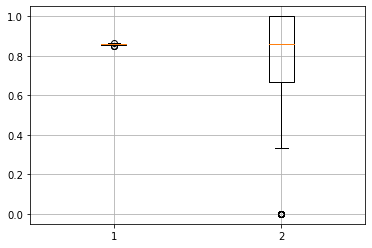

In [66]:
plt.boxplot(np.array(f1_metrics))
plt.grid('on')
plt.show()

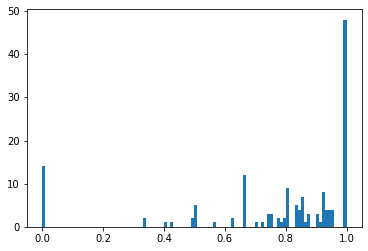

In [68]:
plt.figure()
plt.hist(np.array(f1_metrics)[:,1],bins=100)
plt.show()

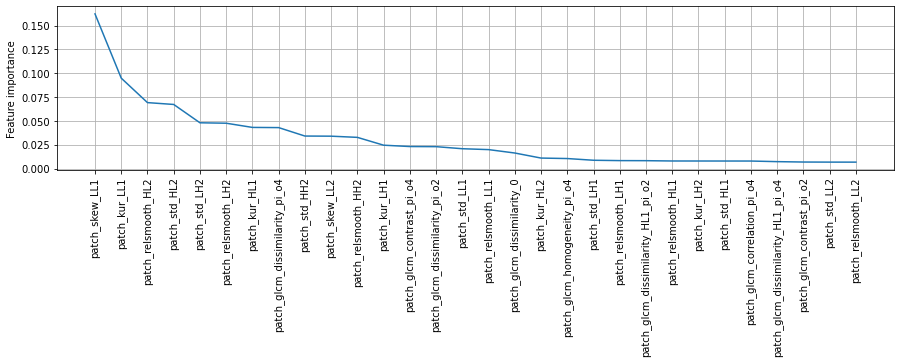

In [69]:
forest_importances = pd.DataFrame(fe_importances,columns=data.columns[:-2])

fe_sorted = forest_importances.mean().sort_values(ascending=False)

plt.figure(figsize=(15,3))
plt.plot(fe_sorted[:30])
plt.xticks(rotation=90)
plt.ylabel('Feature importance')
plt.grid("on")
plt.show()

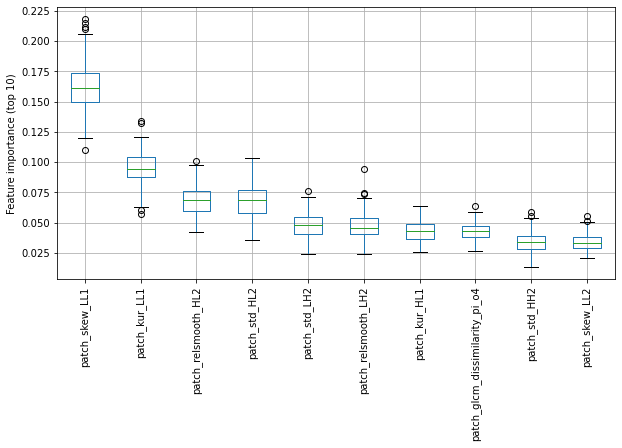

In [70]:
plt.figure(figsize=(10,5))
forest_importances[fe_sorted.index[:10]].boxplot()
plt.xticks(rotation=90)
plt.ylabel('Feature importance (top 10)')
plt.show()
